In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression


## Load dataset

In [3]:
df = pd.read_csv('energy_data.csv')

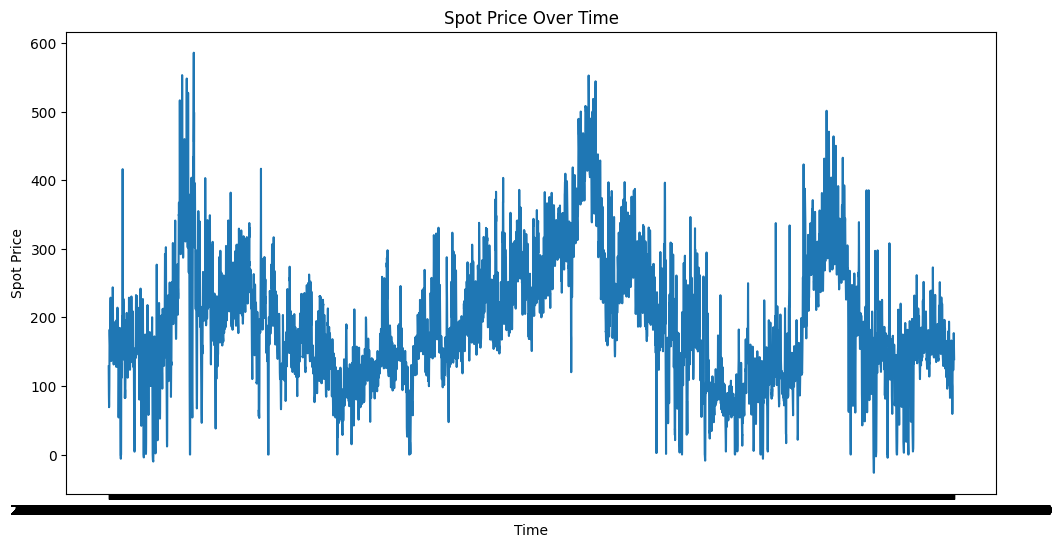

In [ ]:
df.head()
# Visualize spotprices over time
plt.figure(figsize=(12, 6))
plt.plot(df['date_time'], df['spot'], label='Spot Price')
plt.xlabel('Time')
plt.ylabel('Spot Price')
plt.title('Spot Price Over Time')
plt.show()

In [4]:
# ...existing code...
required_cols = [
    'wind_forecast_dah_mw',
    'consumption_forecast_dah_mw',
    'temp_forecast_dah_celcius',
    'temp_norm_celcius',
    'spot'
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in df: {missing}")

train_cols = required_cols[:-1]
train_df = df[train_cols].copy()
true_label = df['spot'].copy()

# drop rows that have NaNs in either X or y
mask = train_df.notna().all(axis=1) & true_label.notna()
train_df = train_df[mask].reset_index(drop=True)
true_label = true_label[mask].reset_index(drop=True)

print(f"train_df shape: {train_df.shape}, true_label shape: {true_label.shape}")

X = train_df.values
y = true_label.values

train_df shape: (8784, 4), true_label shape: (8784,)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
from joblib import Parallel, delayed
from multiprocessing import cpu_count


# 80/20 split
split_idx = int(len(train_df) * 0.8)
X_train, X_test = train_df.iloc[:split_idx], train_df.iloc[split_idx:]
y_train, y_test = true_label.iloc[:split_idx], true_label.iloc[split_idx:]

# Define parameter ranges
p = d = q = range(0, 2)  # try 0, 1, 2 for each
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

seasonal_order = (1, 1, 1, 24)  # fixed

best_bic = float('inf')
best_order = None
best_model = None

def fit_sarimax(order):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = SARIMAX(
                y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            return (order, result.bic, result)
    except Exception as e:
        print(f"SARIMAX{order} failed: {e}")
        return (order, float('inf'), None)

results = Parallel(n_jobs=cpu_count()-1)(
    delayed(fit_sarimax)(order) for order in pdq
)

# Find best model
best_order, best_bic, best_model = min(results, key=lambda x: x[1])
print(f"\nBest SARIMAX order: {best_order} with BIC: {best_bic:.2f}")

# Forecast and plot with best model
forecast = best_model.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
pred_mean = forecast.predicted_mean

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred_mean, label='Predicted', linestyle='--')
plt.title(f'Best SARIMAX{best_order} Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Spot Price')
plt.legend()
plt.show()

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 80/20 split
split_idx = int(len(train_df) * 0.8)
X_train, X_test = train_df.iloc[:split_idx], train_df.iloc[split_idx:]
y_train, y_test = true_label.iloc[:split_idx], true_label.iloc[split_idx:]

# Fit SARIMAX
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)
print(result.summary())
# Forecast
forecast = result.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
pred_mean = forecast.predicted_mean

# Plot
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred_mean, label='Predicted', linestyle='--')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Spot Price')
plt.legend()
plt.show()

KeyboardInterrupt: 